In [1]:
# 'https://hilpisch.com/tr_eikon_eod_data.csv'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
plt.style.use('seaborn-v0_8')
# print(plt.style.available)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# 1 - Linear OLS regression

In [3]:
raw = pd.read_csv('stocks_BR_data.csv',
index_col=0, parse_dates=True).dropna()

In [4]:
raw.columns

Index(['BBAS3.SA', 'ITUB4.SA', 'VALE3.SA', '^BVSP'], dtype='object')

In [5]:
symbol = 'BBAS3.SA'

In [6]:
data = pd.DataFrame(raw[symbol])

In [7]:
data['returns'] = np.log(data / data.shift(1))

In [8]:
data.dropna(inplace=True)

In [9]:
data['direction'] = np.sign(data['returns']).astype(int)

In [10]:
data.head()

,BBAS3.SA,returns,direction
Date,,,
2014-01-03,6.079933,0.010362,1
2014-01-06,5.989678,-0.014956,-1
2014-01-07,5.886881,-0.017311,-1
2014-01-08,5.769043,-0.020220,-1
2014-01-09,5.553426,-0.038091,-1


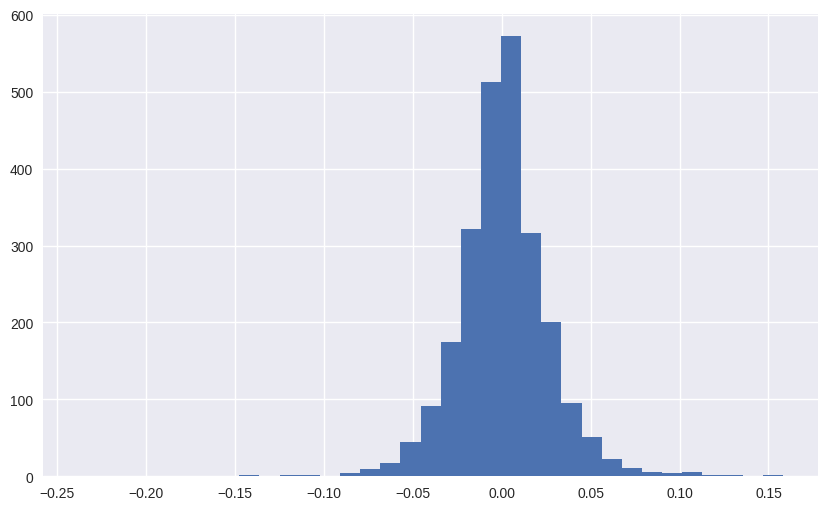

In [11]:
data['returns'].hist(bins=35, figsize=(10, 6));

In [12]:
lags = 2

In [13]:
def create_lags(data):
  global cols
  cols = []
  for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)
    data[col] = data['returns'].shift(lag)
    cols.append(col)

In [14]:
create_lags(data)

In [15]:
data.head()

,BBAS3.SA,returns,direction,lag_1,lag_2
Date,,,,,
2014-01-03,6.079933,0.010362,1,NaN,NaN
2014-01-06,5.989678,-0.014956,-1,0.010362,NaN
2014-01-07,5.886881,-0.017311,-1,-0.014956,0.010362
2014-01-08,5.769043,-0.020220,-1,-0.017311,-0.014956
2014-01-09,5.553426,-0.038091,-1,-0.020220,-0.017311


In [16]:
data.dropna(inplace=True)

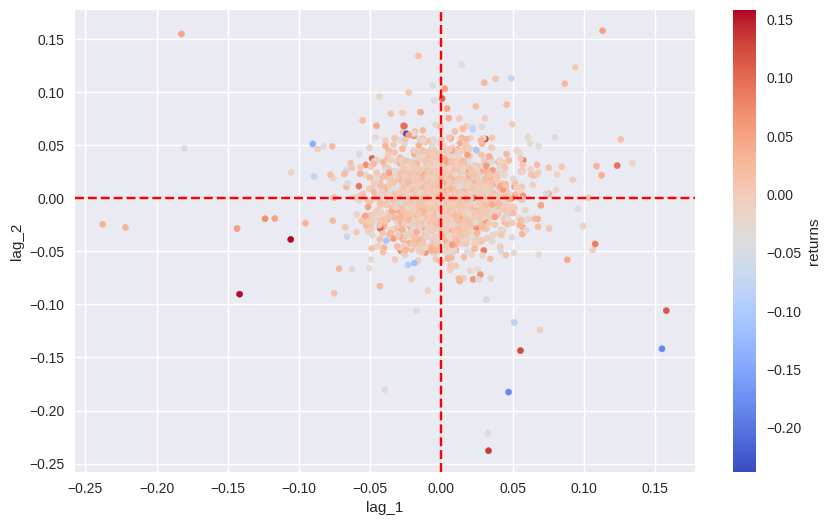

In [17]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');

1 - Linear OLS regression

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
model = LinearRegression()

In [20]:
data[cols]

,lag_1,lag_2
Date,,
2014-01-07,-0.014956,0.010362
2014-01-08,-0.017311,-0.014956
2014-01-09,-0.020220,-0.017311
2014-01-10,-0.038091,-0.020220
2014-01-13,0.035480,-0.038091
...,...,...
2023-12-21,-0.011737,0.003653
2023-12-22,0.001475,-0.011737
2023-12-26,0.002759,0.001475


In [21]:
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])

In [22]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])

In [23]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2014-01-07,0.001024,0.046243
2014-01-08,0.000516,0.021124
2014-01-09,0.000508,0.020267
2014-01-10,0.000708,0.027060
2014-01-13,-0.000753,-0.032044


In [24]:
data[['pos_ols_1', 'pos_ols_2']] = np.where(data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [25]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2014-01-07,1,1
2014-01-08,1,1
2014-01-09,1,1
2014-01-10,1,1
2014-01-13,-1,-1


In [26]:
data['pos_ols_1'].value_counts()

,count
pos_ols_1,
1,2091
-1,382


In [27]:
data['pos_ols_2'].value_counts()

,count
pos_ols_2,
1,2112
-1,361


In [28]:
(data['pos_ols_1'].diff() != 0).sum()

723

In [29]:
(data['pos_ols_2'].diff() != 0).sum()

683

In [30]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [31]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [32]:
data.tail()

,BBAS3.SA,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
Date,,,,,,,,,
2023-12-21,25.045835,0.001475,1,-0.011737,0.003653,1,1,0.001475,0.001475
2023-12-22,25.115032,0.002759,1,0.001475,-0.011737,1,1,0.002759,0.002759
2023-12-26,25.345701,0.009143,1,0.002759,0.001475,1,1,0.009143,0.009143
2023-12-27,25.308794,-0.001457,-1,0.009143,0.002759,1,1,-0.001457,-0.001457
2023-12-28,25.553299,0.009615,1,-0.001457,0.009143,1,1,0.009615,0.009615


In [33]:
print(data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp))

returns        4.266222
strat_ols_1    5.894032
strat_ols_2    6.831117
dtype: float64


In [34]:
(data['direction'] == data['pos_ols_1']).value_counts()

,count
True,1257
False,1216


In [35]:
(data['direction'] == data['pos_ols_2']).value_counts()

,count
True,1254
False,1219


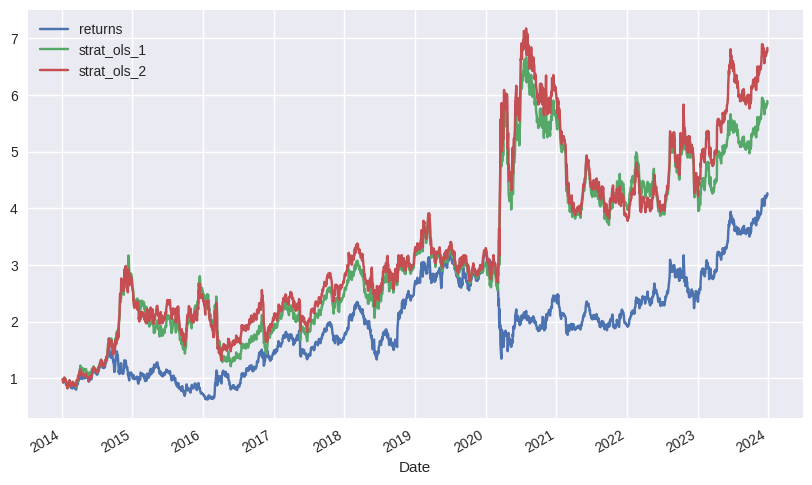

In [36]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum().apply(np.exp).plot(figsize=(10, 6));

It would be nice to test this strategy is US stocks also to see if it works. We could also see that the strategy using the direction performed better than the one using returns.

# 2 - Clustering

In [37]:
from sklearn.cluster import KMeans

In [38]:
model = KMeans(n_clusters=2, random_state=0)

In [39]:
model.fit(data[cols])

KMeans(n_clusters=2, random_state=0)

In [40]:
data['pos_clus'] = model.predict(data[cols])

In [41]:
data['pos_clus']

,pos_clus
Date,
2014-01-07,1
2014-01-08,1
2014-01-09,1
2014-01-10,1
2014-01-13,0
...,...
2023-12-21,1
2023-12-22,0
2023-12-26,1


In [42]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)

In [43]:
data['pos_clus'].values

array([-1, -1, -1, ..., -1,  1, -1])

In [44]:
data.tail()

,BBAS3.SA,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus
Date,,,,,,,,,,
2023-12-21,25.045835,0.001475,1,-0.011737,0.003653,1,1,0.001475,0.001475,-1
2023-12-22,25.115032,0.002759,1,0.001475,-0.011737,1,1,0.002759,0.002759,1
2023-12-26,25.345701,0.009143,1,0.002759,0.001475,1,1,0.009143,0.009143,-1
2023-12-27,25.308794,-0.001457,-1,0.009143,0.002759,1,1,-0.001457,-0.001457,1
2023-12-28,25.553299,0.009615,1,-0.001457,0.009143,1,1,0.009615,0.009615,-1


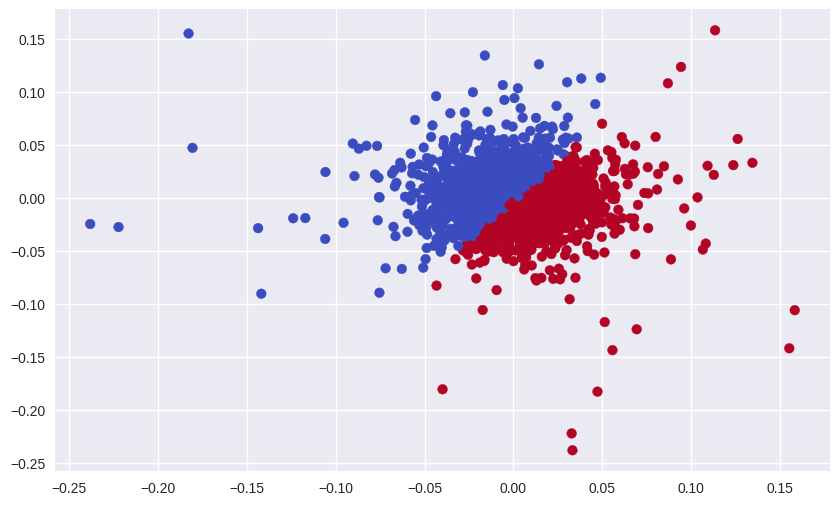

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
c=data['pos_clus'], cmap='coolwarm');

In [46]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [47]:
print(data[['returns', 'strat_clus']].sum().apply(np.exp))

returns       4.266222
strat_clus    1.039786
dtype: float64


In [48]:
(data['direction'] == data['pos_clus']).value_counts()

,count
False,1275
True,1198


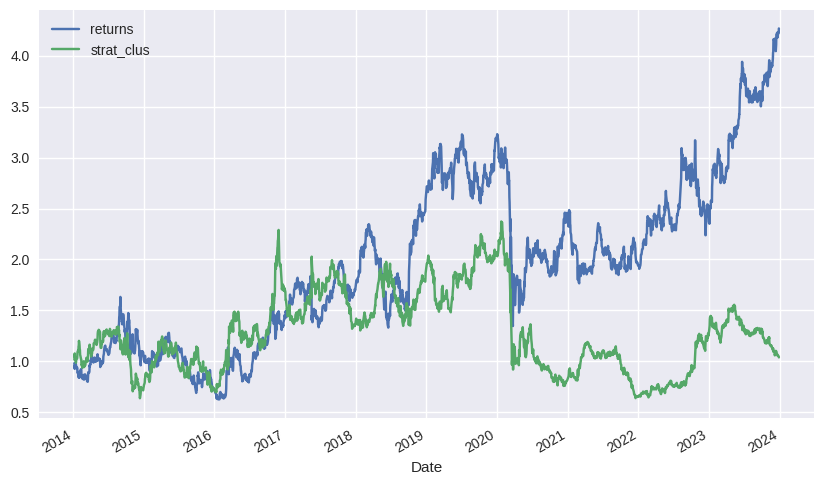

In [49]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [50]:
cols

['lag_1', 'lag_2']

In [51]:
def create_bins(data, bins=[0]):
  global cols_bin
  cols_bin = []
  for col in cols:
    col_bin = col + '_bin'
    data[col_bin] = np.digitize(data[col], bins=bins)
    cols_bin.append(col_bin)

In [52]:
create_bins(data)

In [53]:
data[cols_bin + ['direction']].head()

,lag_1_bin,lag_2_bin,direction
Date,,,
2014-01-07,0,1,-1
2014-01-08,0,0,-1
2014-01-09,0,0,-1
2014-01-10,0,0,1
2014-01-13,1,0,-1


In [54]:
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()

lag_1_bin  lag_2_bin  direction
0          0          -1           269
                       0             3
                       1           294
           1          -1           297
                       0             9
                       1           317
1          0          -1           313
                       0             5
                       1           304
           1          -1           309
                       0            12
                       1           341
dtype: int64

In [55]:
res = grouped['direction'].size().unstack(fill_value=0)

In [56]:
res

direction             -1   0    1
lag_1_bin lag_2_bin              
0         0          269   3  294
          1          297   9  317
1         0          313   5  304
          1          309  12  341

In [57]:
def highlight_max(s):
  is_max = s == s.max()
  return ['background-color: yellow' if v else '' for v in is_max]

In [58]:
res.style.apply(highlight_max, axis=1)

In [59]:
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)

In [60]:
(data['direction'] == data['pos_freq']).value_counts()

,count
False,1249
True,1224


In [61]:
data.tail()

,BBAS3.SA,returns,direction,lag_1,lag_2,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2,pos_clus,strat_clus,lag_1_bin,lag_2_bin,pos_freq
Date,,,,,,,,,,,,,,
2023-12-21,25.045835,0.001475,1,-0.011737,0.003653,1,1,0.001475,0.001475,-1,-0.001475,0,1,1
2023-12-22,25.115032,0.002759,1,0.001475,-0.011737,1,1,0.002759,0.002759,1,0.002759,1,0,1
2023-12-26,25.345701,0.009143,1,0.002759,0.001475,1,1,0.009143,0.009143,-1,-0.009143,1,1,-1
2023-12-27,25.308794,-0.001457,-1,0.009143,0.002759,1,1,-0.001457,-0.001457,1,-0.001457,1,1,-1
2023-12-28,25.553299,0.009615,1,-0.001457,0.009143,1,1,0.009615,0.009615,-1,-0.009615,0,1,1


In [62]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [63]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

,0
returns,4.266222
strat_freq,0.388578


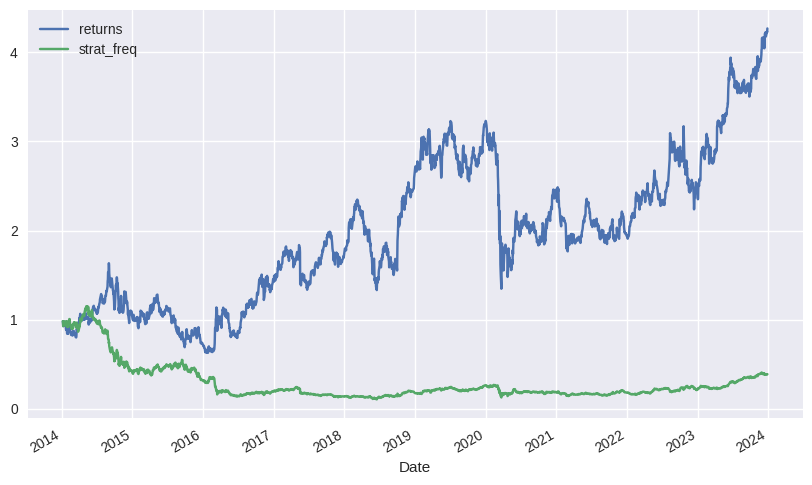

In [64]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));

# 3 - Classification

## 3.1 - Two binary features

In [65]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [66]:
C = 1

In [67]:
models = {
  'log_reg': linear_model.LogisticRegression(C=C),
  'gauss_nb': GaussianNB(),
  'svm': SVC(C=C)
}

In [68]:
def fit_models(data):
  mfit = {model: models[model].fit(data[cols_bin],
  data['direction'])
    for model in models.keys()}

In [69]:
fit_models(data)

In [70]:
models.keys()

dict_keys(['log_reg', 'gauss_nb', 'svm'])

In [71]:
def derive_positions(data):
  for model in models.keys():
    data['pos_' + model] = models[model].predict(data[cols_bin])

In [72]:
derive_positions(data)

In [73]:
def evaluate_strats(data):
  global sel
  sel = []
  for model in models.keys():
    col = 'strat_' + model
    data[col] = data['pos_' + model] * data['returns']
    sel.append(col)
  sel.insert(0, 'returns')

In [74]:
evaluate_strats(data)

In [75]:
sel

['returns', 'strat_log_reg', 'strat_gauss_nb', 'strat_svm']

In [76]:
data[sel]

,returns,strat_log_reg,strat_gauss_nb,strat_svm
Date,,,,
2014-01-07,-0.017311,-0.017311,-0.017311,-0.017311
2014-01-08,-0.020220,-0.020220,-0.020220,-0.020220
2014-01-09,-0.038091,-0.038091,-0.038091,-0.038091
2014-01-10,0.035480,0.035480,0.035480,0.035480
2014-01-13,-0.010953,-0.010953,-0.010953,0.010953
...,...,...,...,...
2023-12-21,0.001475,0.001475,0.001475,0.001475
2023-12-22,0.002759,0.002759,0.002759,-0.002759
2023-12-26,0.009143,0.009143,0.009143,0.009143


In [77]:
sel.insert(1, 'strat_freq')

In [78]:
data[sel].sum().apply(np.exp)

,0
returns,4.266222
strat_freq,0.388578
strat_log_reg,4.266222
strat_gauss_nb,4.266222
strat_svm,7.123985


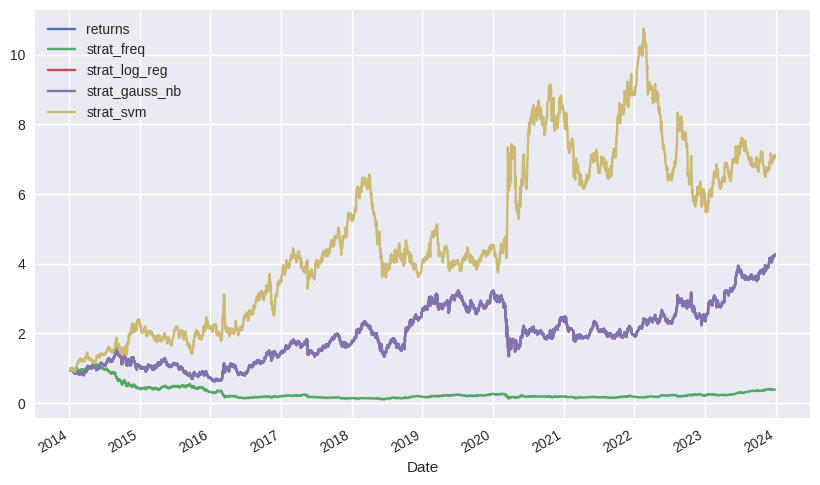

In [79]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

## 3.2 - Five binary features

In [80]:
data = pd.DataFrame(raw[symbol])

In [81]:
data['returns'] = np.log(data / data.shift(1))

In [82]:
data['direction'] = np.sign(data['returns'])

In [83]:
lags = 5
create_lags(data)
data.dropna(inplace=True)

In [84]:
create_bins(data)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [85]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2014-01-10,0,0,0,0,1
2014-01-13,1,0,0,0,0
2014-01-14,0,1,0,0,0
2014-01-15,1,0,1,0,0
2014-01-16,0,1,0,1,0


In [86]:
data.dropna(inplace=True)

In [87]:
fit_models(data)

In [88]:
derive_positions(data)

In [89]:
evaluate_strats(data)

In [90]:
data[sel].sum().apply(np.exp)

,0
returns,4.601358
strat_log_reg,4.775352
strat_gauss_nb,2.155505
strat_svm,276.715395


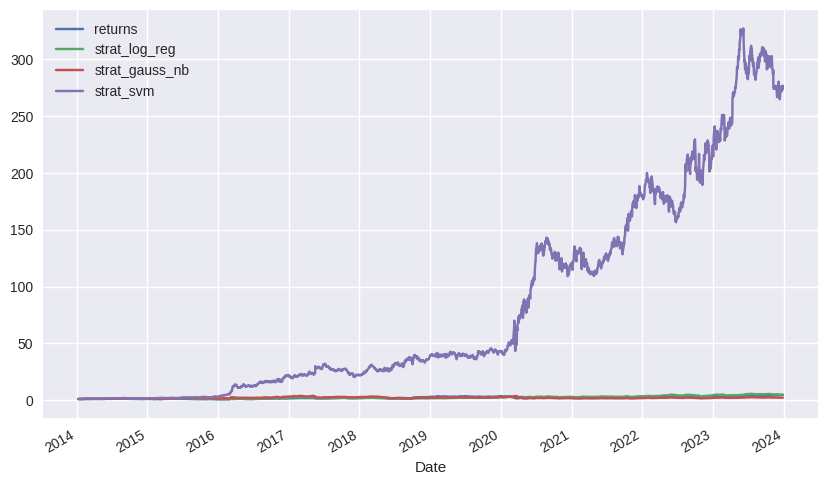

In [91]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [92]:
data = pd.DataFrame(raw[symbol])

In [93]:
data['returns'] = np.log(data / data.shift(1))

In [94]:
data['direction'] = np.sign(data['returns'])

In [95]:
lags = 5
create_lags(data)
data.dropna(inplace=True)

In [96]:
create_bins(data)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [97]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2014-01-10,0,0,0,0,1
2014-01-13,1,0,0,0,0
2014-01-14,0,1,0,0,0
2014-01-15,1,0,1,0,0
2014-01-16,0,1,0,1,0


In [98]:
data.dropna(inplace=True)

In [99]:
fit_models(data)

In [100]:
derive_positions(data)

In [101]:
evaluate_strats(data)

In [102]:
data[sel].sum().apply(np.exp)

,0
returns,4.601358
strat_log_reg,4.775352
strat_gauss_nb,2.155505
strat_svm,276.715395


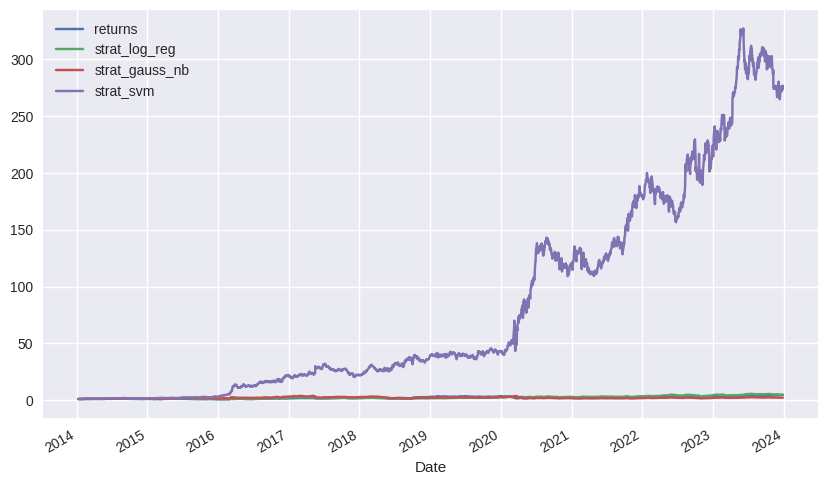

In [103]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [104]:
mu = data['returns'].mean()
v = data['returns'].std()

In [105]:
bins = [mu - v, mu, mu + v]
bins

[-0.026657809711087613, 0.0006179560441900803, 0.027893721799467776]

In [106]:
create_bins(data, bins)

In [107]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2014-01-10,0,1,1,1,2
2014-01-13,3,0,1,1,1
2014-01-14,1,3,0,1,1
2014-01-15,3,1,3,0,1
2014-01-16,1,3,1,3,0


In [108]:
fit_models(data)

In [109]:
derive_positions(data)

In [110]:
evaluate_strats(data)

In [111]:
data[sel].sum().apply(np.exp)

,0
returns,4.601358
strat_log_reg,5.593608
strat_gauss_nb,36.254749
strat_svm,23520.249449


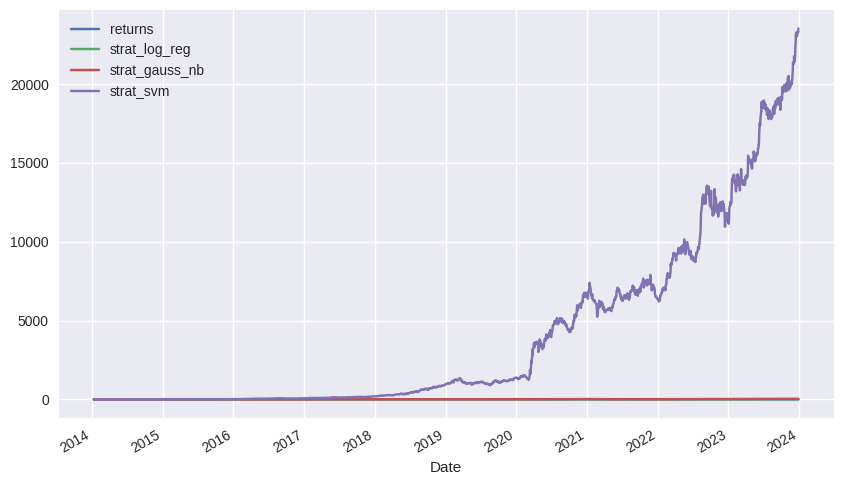

In [112]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

## 3.2 - Train-test split

In [113]:
split = int(len(data) * 0.5)

In [114]:
train = data.iloc[:split].copy()

In [115]:
fit_models(train)

In [116]:
test = data.iloc[split:].copy()

In [117]:
derive_positions(test)

In [118]:
evaluate_strats(test)

In [119]:
test[sel].sum().apply(np.exp)

,0
returns,1.602828
strat_log_reg,0.907445
strat_gauss_nb,2.656212
strat_svm,0.713705


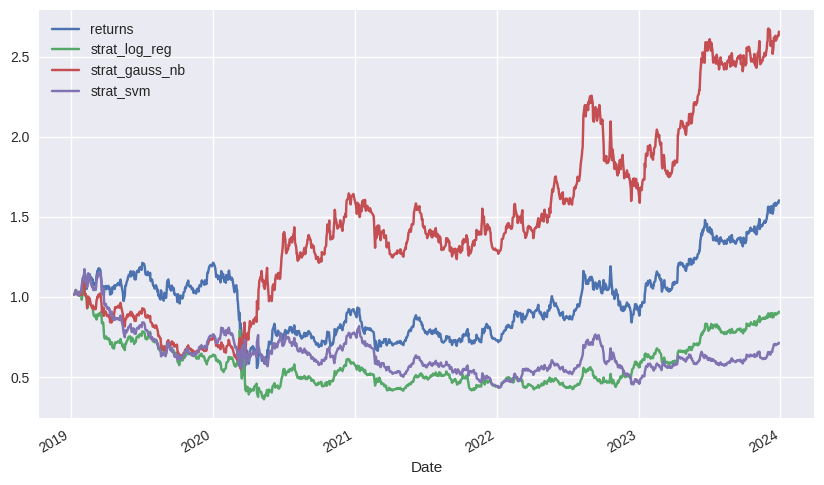

In [120]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [121]:
from sklearn.model_selection import train_test_split

In [122]:
train, test = train_test_split(data, test_size=0.5, shuffle=True, random_state=100)

In [123]:
train.head()

,BBAS3.SA,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin,pos_log_reg,pos_gauss_nb,pos_svm,strat_log_reg,strat_gauss_nb,strat_svm
Date,,,,,,,,,,,,,,,,,,,
2018-01-31,12.686912,0.022427,1.0,-0.003858,-0.005632,0.030588,0.075710,0.004267,1,1,3,3,2,1.0,1.0,-1.0,0.022427,0.022427,-0.022427
2021-04-16,11.359683,0.004377,1.0,0.001350,0.001691,0.000000,0.012257,0.002744,2,2,1,2,2,1.0,1.0,1.0,0.004377,0.004377,0.004377
2016-09-30,7.018712,0.007484,1.0,-0.029606,0.018619,0.008339,-0.011393,-0.021552,0,2,2,1,1,1.0,1.0,-1.0,0.007484,0.007484,-0.007484
2018-02-27,13.620529,-0.009811,-1.0,0.014517,0.000000,0.030654,0.007813,0.029095,2,1,3,2,3,-1.0,-1.0,-1.0,0.009811,0.009811,0.009811
2015-12-10,5.249039,-0.043485,-1.0,0.095949,-0.009904,-0.004050,-0.027337,0.080699,3,1,1,0,3,-1.0,-1.0,-1.0,0.043485,0.043485,0.043485


In [124]:
train = train.copy().sort_index()

In [126]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2014-01-14,1,3,0,1,1
2014-01-15,3,1,3,0,1
2014-01-20,1,1,1,3,1
2014-01-21,1,1,1,1,3
2014-01-27,1,0,2,2,1


In [127]:
test = test.copy().sort_index()

In [128]:
fit_models(train)

In [129]:
derive_positions(test)

In [130]:
evaluate_strats(test)

In [131]:
test[sel].sum().apply(np.exp)

,0
returns,1.515681
strat_log_reg,0.236601
strat_gauss_nb,0.448647
strat_svm,0.218552


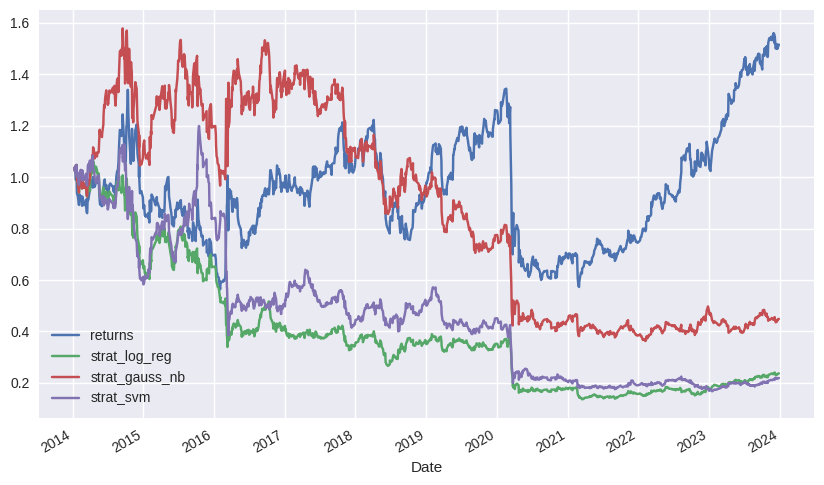

In [132]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [133]:
from sklearn.neural_network import MLPClassifier

In [134]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)

In [135]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 42.6 s, sys: 10.2 s, total: 52.9 s
Wall time: 31.9 s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[250, 250], random_state=1,
              solver='lbfgs')

In [136]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [137]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [138]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

,0
returns,4.601358e+00
strat_dnn_sk,8.993608e+07


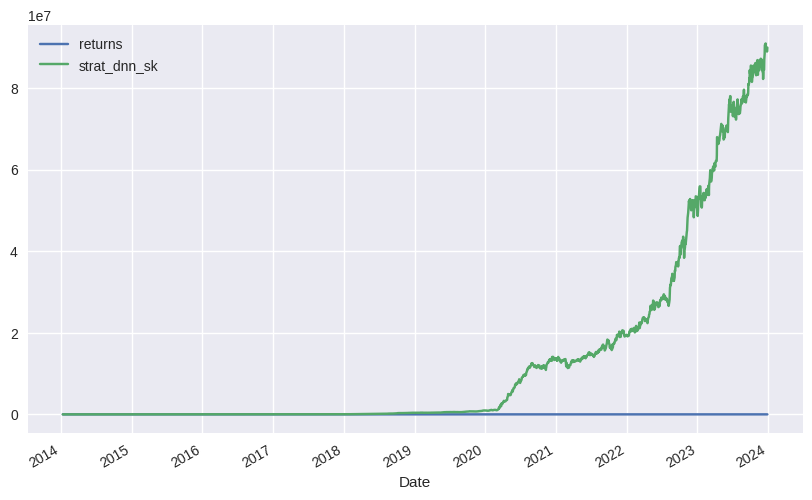

In [139]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(
 np.exp).plot(figsize=(10, 6));

In [140]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [141]:
train = train.copy().sort_index()

In [142]:
test = test.copy().sort_index()

In [143]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, hidden_layer_sizes=3 * [500], random_state=1)

In [144]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 4min 40s, sys: 58.3 s, total: 5min 38s
Wall time: 3min 24s


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=[500, 500, 500], max_iter=500,
              random_state=1, solver='lbfgs')

In [145]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [146]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

,0
returns,1.515681
strat_dnn_sk,3847.206721


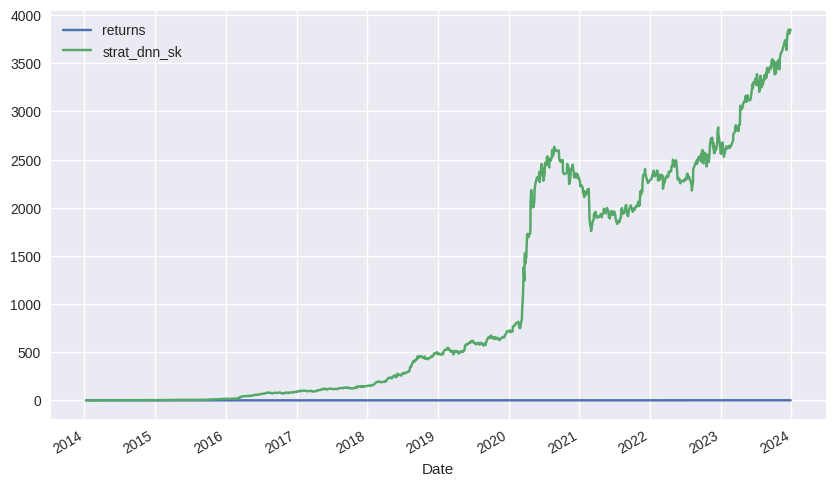

In [147]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));